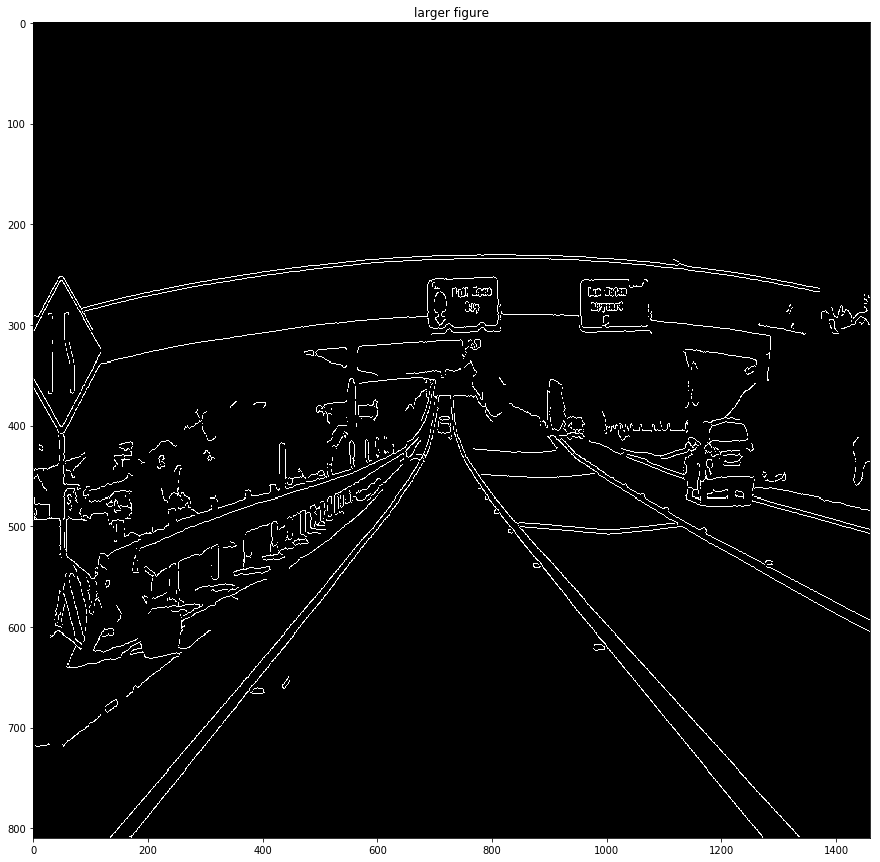

In [101]:
#doing all the relevant imports
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
#
image = mpimg.imread('highway.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# change the figure size
fig2 = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(edges, cmap='Greys_r', aspect='auto')
ax3.set_title('larger figure')

plt.show()

# Display the image
#plt.imshow(edges, cmap='Greys_r', aspect='auto')

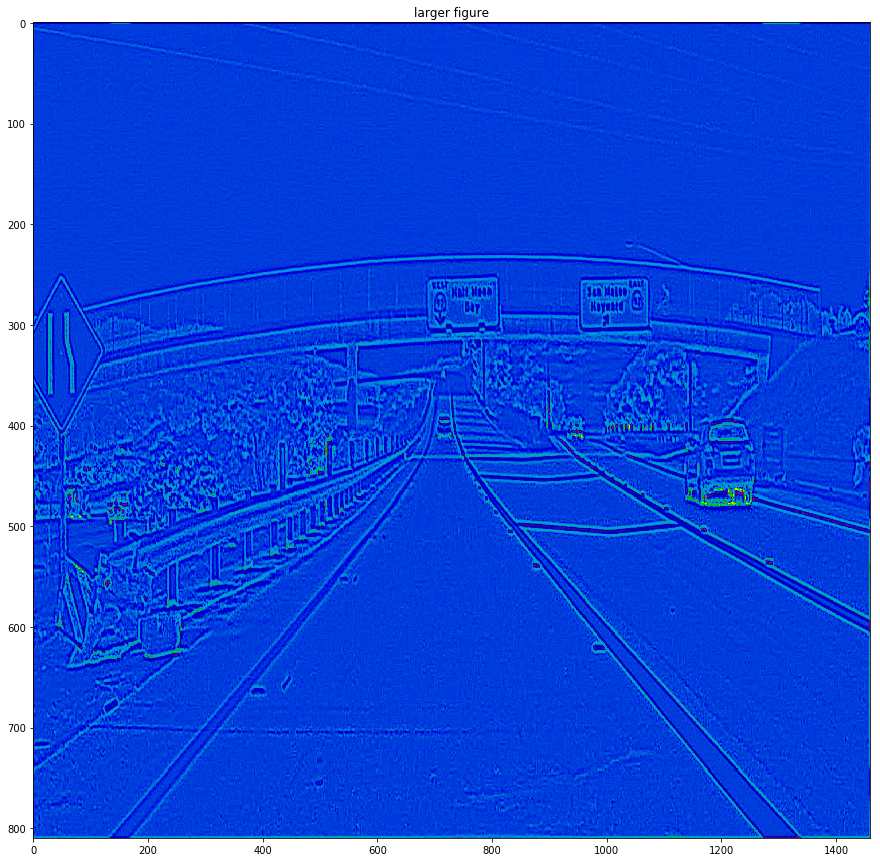

In [102]:
#doing all the relevant imports
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
#
image = mpimg.imread('highway.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def pst(image, lpf=0.5, phase_strength=0.5, warp_strength=0.5, thresh_min=-0.5, thresh_max=0.5, morph_flag=False):
    # port of https://github.com/JalaliLabUCLA/Image-feature-detection-using-Phase-Stretch-Transform
    # restrictions on usage apply, consult the original source!
    import numpy
    from numpy.fft import fft2, ifft2, fftshift

    def cart2pol(x, y):
        return numpy.arctan2(y, x), numpy.hypot(x, y)

    image = image.astype(numpy.float64)

    L = 0.5

    x = numpy.linspace(-L, L, image.shape[1])
    y = numpy.linspace(-L, L, image.shape[0])

    X, Y = numpy.meshgrid(x, y)

    THETA, RHO = cart2pol(X, Y)

    X_step = x[1]-x[0]
    Y_step = y[1]-y[0]

    fx = numpy.linspace(-L/X_step, L/X_step, len(x))
    fy = numpy.linspace(-L/Y_step, L/Y_step, len(y))

    fx_step = fx[1]-fx[0]
    fy_step = fy[1]-fy[0]

    FX, FY = numpy.meshgrid(fx_step, fy_step)

    FTHETA, FRHO = cart2pol(FX, FY)

    # lowpass

    sigma = (lpf ** 2) / numpy.log(2)

    image_f = fft2(image)   
    image_f = image_f * fftshift(numpy.exp(-(RHO / numpy.sqrt(sigma))**2))
    image_filtered = numpy.real(ifft2(image_f))

    # PST kernel construction

    rws = RHO*warp_strength
    pst_kernel = rws * numpy.arctan(rws) - 0.5*numpy.log(1+(rws**2))
    pst_kernel /= pst_kernel.max()
    pst_kernel *= phase_strength

    # application of the kernel, and phase calculation

    image_processed = ifft2(fft2(image_filtered) * fftshift(numpy.exp(-1j * pst_kernel)))

    result = numpy.angle(image_processed)

    if morph_flag == False:
        return result
    else:
        binary = numpy.zeros_like(image, dtype=bool)

        binary[result > thresh_max] = 1
        binary[result < thresh_min] = 1    
        binary[image < image.max() / 20] = 0

        # the matlab version does post-processing (cleaning) here!

        return binary

# def pst(image, lpf=0.5, phase_strength=0.5, warp_strength=0.5, thresh_min=-0.5, thresh_max=0.5, morph_flag=False):
trans= pst(gray, 0.22, 0.9, 0.1, -0.5, 0.5, False)
# change the figure size
fig2 = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
#ax3.imshow(trans, cmap='Greys_r', aspect='auto')
# cmaps: https://matplotlib.org/examples/color/colormaps_reference.html
ax3.imshow(trans, cmap='nipy_spectral', aspect='auto')
ax3.set_title('larger figure')

plt.show()


##### 

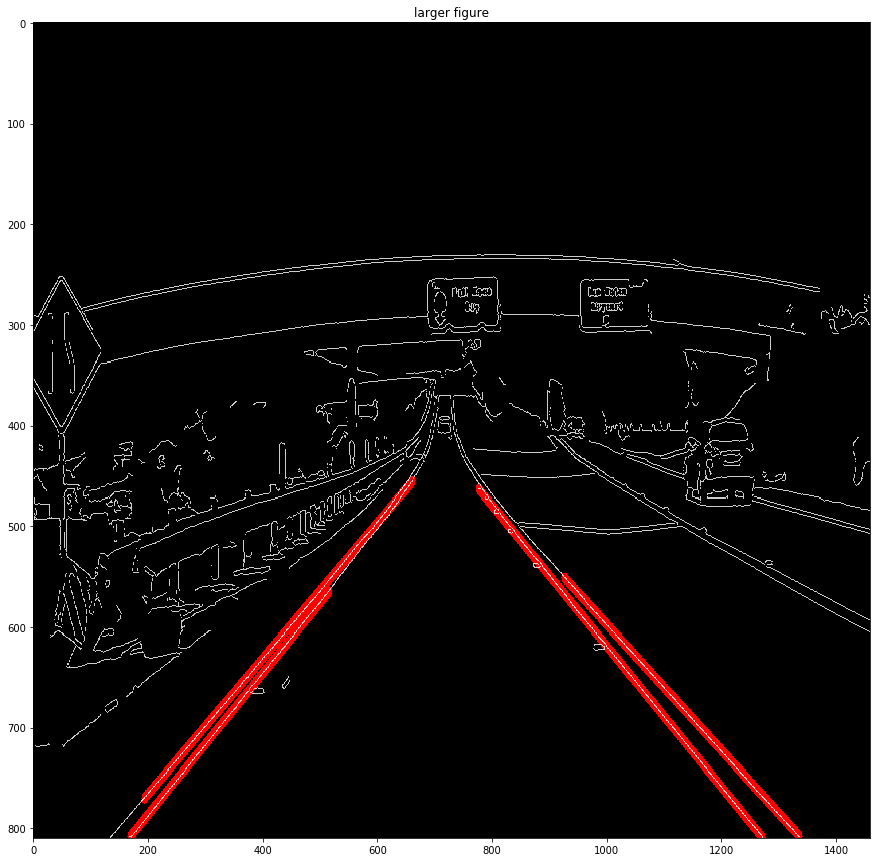

In [144]:
%matplotlib inline
#######
# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in and grayscale the image
image = mpimg.imread('highway.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 250     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 340 #minimum number of pixels making up a line
max_line_gap = 50    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

#########
# change the figure size
fig2 = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(lines_edges, cmap='Greys_r', aspect='auto')
ax3.set_title('larger figure')

plt.show()

# Display the image
#plt.imshow(edges, cmap='Greys_r', aspect='auto')

In [146]:
### DOESNT WORK
#doing all the relevant imports
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
#
image = mpimg.imread('highway.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def pst(image, lpf=0.5, phase_strength=0.5, warp_strength=0.5, thresh_min=-0.5, thresh_max=0.5, morph_flag=False):
    # port of https://github.com/JalaliLabUCLA/Image-feature-detection-using-Phase-Stretch-Transform
    # restrictions on usage apply, consult the original source!
    import numpy
    from numpy.fft import fft2, ifft2, fftshift

    def cart2pol(x, y):
        return numpy.arctan2(y, x), numpy.hypot(x, y)

    image = image.astype(numpy.float64)

    L = 0.5

    x = numpy.linspace(-L, L, image.shape[1])
    y = numpy.linspace(-L, L, image.shape[0])

    X, Y = numpy.meshgrid(x, y)

    THETA, RHO = cart2pol(X, Y)

    X_step = x[1]-x[0]
    Y_step = y[1]-y[0]

    fx = numpy.linspace(-L/X_step, L/X_step, len(x))
    fy = numpy.linspace(-L/Y_step, L/Y_step, len(y))

    fx_step = fx[1]-fx[0]
    fy_step = fy[1]-fy[0]

    FX, FY = numpy.meshgrid(fx_step, fy_step)

    FTHETA, FRHO = cart2pol(FX, FY)

    # lowpass

    sigma = (lpf ** 2) / numpy.log(2)

    image_f = fft2(image)   
    image_f = image_f * fftshift(numpy.exp(-(RHO / numpy.sqrt(sigma))**2))
    image_filtered = numpy.real(ifft2(image_f))

    # PST kernel construction

    rws = RHO*warp_strength
    pst_kernel = rws * numpy.arctan(rws) - 0.5*numpy.log(1+(rws**2))
    pst_kernel /= pst_kernel.max()
    pst_kernel *= phase_strength

    # application of the kernel, and phase calculation

    image_processed = ifft2(fft2(image_filtered) * fftshift(numpy.exp(-1j * pst_kernel)))

    result = numpy.angle(image_processed)

    if morph_flag == False:
        return result
    else:
        binary = numpy.zeros_like(image, dtype=bool)

        binary[result > thresh_max] = 1
        binary[result < thresh_min] = 1    
        binary[image < image.max() / 20] = 0

        # the matlab version does post-processing (cleaning) here!

        return binary

# def pst(image, lpf=0.5, phase_strength=0.5, warp_strength=0.5, thresh_min=-0.5, thresh_max=0.5, morph_flag=False):
trans= pst(gray, 0.22, 0.9, 0.1, -0.5, 0.5, False)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(trans)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(trans, mask)

#######
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 250     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 340 #minimum number of pixels making up a line
max_line_gap = 50    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(trans, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((trans, trans, trans)) 

#######
# change the figure size
fig2 = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
#ax3.imshow(trans, cmap='Greys_r', aspect='auto')
# cmaps: https://matplotlib.org/examples/color/colormaps_reference.html
ax3.imshow(color_edges, cmap='nipy_spectral', aspect='auto')
ax3.set_title('larger figure')

plt.show()

TypeError: Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)